In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import pickle

import matplotlib.cm as cm

from fastai import *
from fastai.text import *

from pathlib import Path

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss, zero_one_loss, accuracy_score

In [3]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [4]:
!python -m fastai.utils.show_install



```text
=== Software === 
python        : 3.7.4
fastai        : 1.0.57
fastprogress  : 0.1.21
torch         : 1.0.1.post2
nvidia driver : 410.72
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 7611MB | Tesla P4

=== Environment === 
platform      : Linux-4.9.0-8-amd64-x86_64-with-debian-9.8
distro        : #1 SMP Debian 4.9.130-2 (2018-10-27)
conda env     : base
python        : /opt/anaconda3/bin/python
sys.path      : /home/jupyter/kneedle-exploration
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload
/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once

In [4]:
bs=32

## Loading Data

In [5]:
path = Path(".")

In [6]:
df = pd.read_csv(path/"data/clean/train.csv")

In [7]:
df

,label,text,is_valid
0,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
1,SECRETARIA DE ESTADO DE CULTURA,PROCESSO: 00150-00010629/2018-72; NOTA DE EMPE...,False
2,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
3,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A Comissão Permanente de Licitação do BRB - BA...,False
4,CASA CIVIL,A ADMINISTRADORA REGIONAL DE TAGUATINGA DO DIS...,False
...,...,...,...
712,SECRETARIA DE ESTADO DE OBRAS E INFRAESTRUTURA,O Pregoeiro da CAESB no uso de suas atribuiçõe...,True
713,SECRETARIA DE ESTADO DE DESENVOLVIMENTO ECONÔMICO,"O SUBSECRETÁRIO DE ADMINISTRAÇÃO GERAL, DA SEC...",True
714,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR DO DEPARTAMENTO DE GESTÃO DE PESSOAS...,True
715,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,PROCESSO: 00054-00027353/2018-03. PARTES: DF/P...,True


In [8]:
df_train = df[df["is_valid"] == False]; df_train

,label,text,is_valid
0,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
1,SECRETARIA DE ESTADO DE CULTURA,PROCESSO: 00150-00010629/2018-72; NOTA DE EMPE...,False
2,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
3,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A Comissão Permanente de Licitação do BRB - BA...,False
4,CASA CIVIL,A ADMINISTRADORA REGIONAL DE TAGUATINGA DO DIS...,False
...,...,...,...
475,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A DIRETORA PRESIDENTE DO INSTITUTO DE PREVIDÊN...,False
476,SECRETARIA DE ESTADO DE SAÚDE,A DIRETORA DO HOSPITAL MATERNO INFANTIL DE BRA...,False
477,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
478,"SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIM...","O SUBSECRETÁRIO DE ADMINISTRAÇÃO GERAL, DA SEC...",False


In [9]:
df_test = df[df["is_valid"] == True]; df_test

,label,text,is_valid
480,CASA CIVIL,"A COORDENADORA DE ADMINISTRAÇÃO GERAL, DA ADMI...",True
481,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,True
482,SECRETARIA DE ESTADO DE TRANSPORTE E MOBILIDADE,"O SUPERINTENDENTE DE OPERAÇÕES, DO DEPARTAMENT...",True
483,SECRETARIA DE ESTADO DE SAÚDE,"O Subsecretário de Administração Geral, Substi...",True
484,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,True
...,...,...,...
712,SECRETARIA DE ESTADO DE OBRAS E INFRAESTRUTURA,O Pregoeiro da CAESB no uso de suas atribuiçõe...,True
713,SECRETARIA DE ESTADO DE DESENVOLVIMENTO ECONÔMICO,"O SUBSECRETÁRIO DE ADMINISTRAÇÃO GERAL, DA SEC...",True
714,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR DO DEPARTAMENTO DE GESTÃO DE PESSOAS...,True
715,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,PROCESSO: 00054-00027353/2018-03. PARTES: DF/P...,True


In [10]:
df_lm = pd.read_csv(path/'data/clean/unsup/unsup.csv'); df_lm

,text
0,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...
1,A Comissão Permanente de Licitação da BRB ADMI...
2,PROCESSO Nº 00095-00002392/2018-12.\nO DIRETOR...
3,Partes: DETRAN-DF e a empresa SINASC SINALIZAÇ...
4,Espécie: Contrato nº 647/2018-CEB DISTRIBUIÇÃO...
...,...
1921,O Secretário de Estado de Cultura do Distrito ...
1922,PROCESSO Nº 00150-00010640/2018-32\nCLÁUSULA P...
1923,Processo: 00220-00005431/2018-32 - Das Partes:...
1924,Processo: PROCESSO 00220-00005706/2018-38. Par...


In [12]:
data_lm = (TextList.from_df(df_lm,cols='text', processor=SPProcessor(max_vocab_sz=15000))
                           .split_by_rand_pct(0.2, seed=seed)
                           .label_for_lm()
                           .databunch(bs=bs))

In [13]:
data_lm.show_batch()

idx,text
0,"▁2011, ▁e ▁conforme ▁xxmaj ▁processo ▁xxup ▁sei ▁no ▁00055-001 65 43 7 ▁/ ▁2018-16 , ▁resolve : ▁xxup ▁designar ▁xxup ▁edson ▁xxup ▁de ▁xxup ▁campos ▁xxup ▁júnior , ▁xxmaj ▁assistente ▁de ▁xxmaj ▁trânsito , ▁matrícula ▁1.2 03 -3, ▁para ▁substituir ▁xxup ▁francisco ▁xxup ▁de r i ck ▁xxup ▁sousa ▁xxup ▁carvalho , ▁xxmaj ▁assistente ▁de ▁xxmaj ▁trânsito , ▁matrícula ▁250.44 1-3, ▁chefe , ▁símbolo ▁xxup ▁dfg -12, ▁do ▁xxmaj ▁núcleo"
1,"▁xxmaj ▁vida ▁xxmaj ▁pre gressa ▁e ▁xxmaj ▁investigação ▁xxmaj ▁social ▁e ▁xxmaj ▁funcional , ▁for ▁considerado ▁contraindicado . ▁ 3.11 ▁xxmaj ▁será ▁eliminado ▁do ▁xxmaj ▁concurso ▁o ▁candidato ▁que ▁deix ar ▁de ▁faze r ▁a ▁entrega ▁de ▁um ▁ou ▁mais ▁documentos ▁exigido s ▁no ▁presente ▁edital , ▁o mit ir ▁informação ▁solicitada ▁ou ▁prestar ▁informação ▁fal s a . ▁3.1 2 ▁xxmaj ▁a pós ▁a ▁sindicância ▁da ▁vida ▁pre gressa"
2,"▁xxup ▁silva ▁xxup ▁alexandre , ▁matr . ▁14 04 19 3; ▁xxup ▁jos é ▁xxup ▁carlo s ▁xxup ▁xavier ▁xxup ▁de ▁xxup ▁lima , ▁matr . ▁14 041 95 ; ▁xxup ▁wander ▁xxup ▁ribeiro ▁xxup ▁da ▁xxup ▁silva , ▁matr . ▁14 04 196 ; ▁xxup ▁jos é ▁xxup ▁ ni lson ▁xxup ▁rodrigues ▁xxup ▁da ▁xxup ▁silva , ▁matr . ▁14 041 99 ; ▁xxup ▁di lson ▁xxup ▁fernandes"
3,"▁no ▁xxup ▁dodf ▁n ° ▁117 ▁de ▁10 ▁de ▁junho ▁de ▁2013, ▁pág . ▁55, ▁o ▁ato ▁que ▁averb ou ▁o ▁tempo ▁de ▁serviço ▁do ▁servidor ▁xxup ▁an isio ▁xxup ▁sousa ▁xxup ▁neto , ▁matrícula ▁xxup ▁129 .010- x , ▁xxmaj ▁odontólog o , ▁xxmaj ▁secretaria ▁de ▁xxmaj ▁estado ▁de ▁xxmaj ▁saúde ▁do ▁xxup ▁df . ▁xxup ▁onde ▁xxup ▁se ▁xxup ▁lê : ▁""...1.5 41 ▁dias , ▁ou ▁seja ,"
4,"▁19 ▁de ▁ju lho ▁de ▁2018, ▁publicada ▁no ▁xxup ▁dodf ▁no ▁ 137 , ▁de ▁20 ▁de ▁ju lho ▁de ▁2018. ▁xxmaj ▁art . ▁2 o ▁xxmaj ▁designar ▁xxup ▁fernand o ▁xxup ▁mendes ▁xxup ▁rodrigues ▁xxup ▁para gu assu , ▁matrícula ▁no ▁79. 25 3-5, ▁xxmaj ▁analista ▁em ▁xxmaj ▁políticas ▁xxmaj ▁públicas ▁e ▁xxmaj ▁gestão ▁xxmaj ▁governamental , ▁e ▁xxup ▁robert son ▁xxup ▁freitas ▁xxup ▁lima , ▁matrícula ▁no ▁267.73"


In [14]:
data_lm.save('data/data_lm_export.pkl')

In [15]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [11]:
perplexity = Perplexity()
f1 = FBeta(beta=1, average="weighted")

In [17]:
lm_fns3 = ['pt_wt_sp15_multifit', 'pt_wt_vocab_sp15_multifit']
lm_fns3_bwd = ['pt_wt_sp15_multifit_bwd', 'pt_wt_vocab_sp15_multifit_bwd']

## Fine-tune forward LM

In [18]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns3, drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [20]:
learn_lm.predict("O Governo", n_words=20)

'O Governo ▁xxmaj ▁federal ▁de ▁xxmaj ▁santa ▁xxmaj ▁catarina ▁ - ▁xxup ▁sp ▁é ▁um ▁órgão ▁que ▁foi ▁realizado ▁pela ▁xxmaj ▁união'

In [21]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


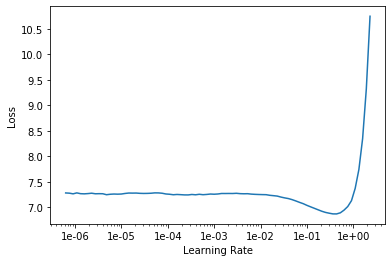

In [22]:
learn_lm.recorder.plot()

In [23]:
lr = 1e-1

In [24]:
learn_lm.fit_one_cycle(2, lr, wd=0.1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,8.167725,4.989687,0.871429,0.128571,146.890518,00:31
1,5.184942,3.518033,0.628571,0.371429,33.718025,00:32


In [25]:
learn_lm.save('fine_tune_lm')
learn_lm.save_encoder('fine_tune_enc')

In [26]:
learn_lm.unfreeze()
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


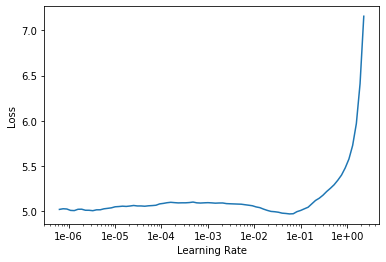

In [27]:
learn_lm.recorder.plot()

In [28]:
lr = 1e-2

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.990016,1.942214,0.428571,0.571429,6.974174,00:47
1,2.871821,0.718581,0.185714,0.814286,2.051521,00:47
2,2.491171,0.470399,0.157143,0.842857,1.600633,00:47
3,2.102498,0.303143,0.085714,0.914286,1.354108,00:47
4,1.960301,0.253956,0.100000,0.900000,1.289115,00:47
5,1.909165,0.197701,0.071429,0.928571,1.218598,00:47
6,1.647301,0.164117,0.057143,0.942857,1.178352,00:47
7,1.592349,0.130880,0.042857,0.957143,1.139831,00:47
8,1.504651,0.140475,0.042857,0.957143,1.150821,00:47
9,1.426316,0.129106,0.028571,0.971429,1.137810,00:47


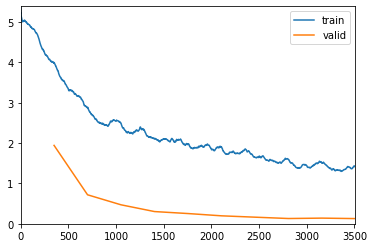

In [29]:
learn_lm.fit_one_cycle(10, lr, wd=0.1, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

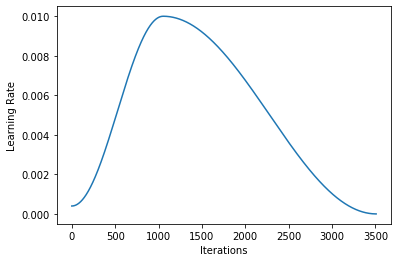

In [30]:
learn_lm.recorder.plot_lr()

In [31]:
learn_lm.predict("O Governo", n_words=30)

'O Governo ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere m ▁os ▁artigos ▁20, ▁incisos ▁xxup ▁ii , ▁xxup ▁iii , ▁xxup ▁iv , ▁i ▁e ▁xxup'

In [32]:
learn_lm.save('fine_tune_lm')
learn_lm.save_encoder('fine_tune_enc')

## Fine-tune backward LM

In [33]:
data_lm = (TextList.from_df(df_lm,cols='text', processor=SPProcessor.load(path))
                           .split_by_rand_pct(0.2, seed=seed)
                           .label_for_lm()
                           .databunch(bs=bs, backwards=True))

In [34]:
data_lm.show_batch()

idx,text
0,"▁do ▁termos ▁nos , comprasnet ▁ ▁do ▁sítio ▁no ada ▁process ▁será ▁pública ▁xxmaj ▁sessão ▁xxmaj ▁a ). 3 ▁97400 : uasg ▁( ▁xxup br . gov . comprasnet . ww ▁w ▁e br . gov . df . tc . ww ▁w : ▁sítios ▁pelos ▁ou 742 ▁3314-2 61) ▁( ▁telefone , ▁tcdf ▁xxup ▁do ▁anexo ▁xxmaj . ▁ed ▁xxmaj ▁do ▁andar ▁xxmaj o ▁2 ▁no ▁localizado , ▁licitação"
1,"s ▁regra ▁as ▁e ▁pertinente ▁legislação ▁a ▁com sonância ▁con ▁em ▁mencionadas ▁acima ▁disposições ▁das ância ▁observ ▁fiel ▁da os ▁incumbid ▁servidores ▁mencionados ▁os ▁ficam ▁xxmaj o ▁2 . ▁art ▁xxmaj . financeira - ▁administrativo ▁atividades ▁xxmaj ▁das ▁coordenação ▁xxmaj ▁na ém b ▁tam á ▁atuar ▁fiscalização ▁na ▁atuar ▁de ém ▁al ▁lopes ▁xxmaj s ▁marti ▁xxmaj ▁rodrigues ▁xxmaj ▁paiva ▁xxmaj ▁de ▁thais ▁xxmaj ▁servidora ▁a ▁que ▁sendo , ▁83.359-2"
2,", ▁03 - ▁cnp ▁xxup ▁símbolo ▁xxmaj , ▁política ▁xxmaj ▁natureza ▁xxmaj ▁de ▁cargo ▁xxmaj ▁do , ▁silva ▁xxup ▁da ▁xxup ▁martins ▁xxup ileu rg ▁a ▁xxup , ▁pedido ▁a , ▁exonerar ▁xxup . ▁federal ▁distrito ▁xxmaj ▁do ▁comunicação ▁xxmaj ▁de ▁estado ▁xxmaj ▁de ▁secretaria ▁xxmaj ▁da , ▁estado ▁xxmaj ▁de ▁secretário ▁xxmaj ▁de , -03 ▁cnp ▁xxup ▁símbolo ▁xxmaj , ▁política ▁xxmaj ▁natureza ▁xxmaj ▁de ▁cargo ▁xxmaj ▁do ,"
3,"i ▁fil ▁xxup 31, 71 ▁19713 ; ▁moura ▁xxup ▁moreira ▁xxup ▁borges ▁xxup pe i ▁fil ▁xxup 74, 74 ▁19712 ; la ndo ▁espi ▁xxup da e bi ▁ ▁xxup pe i ▁fil ▁xxup 75, 26 10 ▁197 ; cao ▁concei ▁xxup ▁da ▁xxup ▁barbosa ▁xxup pe i ▁fil ▁xxup 83, 11 ▁19712 ; ▁fernandes ▁xxup ▁alencar ▁xxup pe i ▁fil ▁xxup 104, 0 ▁19713 ; ▁cardoso ▁xxup ▁ribeiro ▁xxup"
4,"▁xxmaj ▁de ▁comissão ▁xxmaj stituírem ▁con , ▁primeiro ▁do ▁presidência ▁a ▁sob , ▁para -4; 45 ▁215.7 ▁no ▁matrícula , ▁ambiente ▁xxmaj ▁meio ▁xxmaj ▁do ▁atividades ▁xxmaj ▁de ▁analista ▁xxmaj , ▁mesquita ▁xxup ▁de ▁xxup ▁gonçalves ▁xxup o ▁fábi ▁xxup ▁luis ▁xxup ▁e ; x .259- 4 ▁26 ▁xxup ▁no ▁matrícula , ▁urbanas ▁xxmaj ▁atividades ▁xxmaj ▁de ▁fiscal ▁xxmaj ▁auditora ▁xxmaj , ▁mendes ▁xxup ▁moraes ▁xxup ▁de ▁xxup a ▁flávi"


In [35]:
data_lm.save('./data/data_lm_back.pkl')

In [36]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns3_bwd, drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [37]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


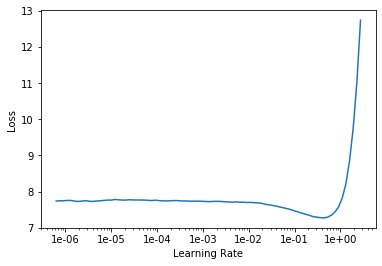

In [38]:
learn_lm.recorder.plot()

In [39]:
lr=1e-1

In [40]:
learn_lm.fit_one_cycle(2, lr, wd=0.1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,10.990892,6.967726,0.893869,0.106131,1061.806641,00:37
1,6.019197,5.803520,0.876508,0.123492,331.464020,00:37


In [41]:
learn_lm.save('fine_tune_lm_bwd')
learn_lm.save_encoder('fine_tune_enc_bwd')

In [42]:
learn_lm.unfreeze()
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


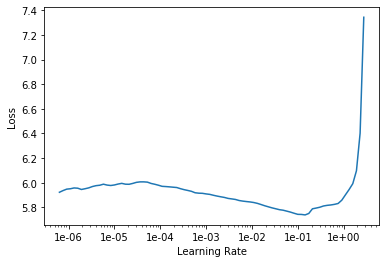

In [43]:
learn_lm.recorder.plot()

In [44]:
lr=1e-2

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,5.191076,5.076291,0.757674,0.242326,160.178864,00:51
1,3.419759,3.568627,0.567158,0.432842,35.467808,00:51
2,2.583399,2.996648,0.499315,0.500685,20.018311,00:51
3,2.250463,2.721676,0.466091,0.533909,15.205795,00:51
4,2.143383,2.579690,0.446171,0.553829,13.193041,00:51
5,1.924962,2.459377,0.426850,0.573150,11.697512,00:51
6,1.729249,2.360579,0.409846,0.590154,10.597078,00:51
7,1.701375,2.285222,0.395030,0.604970,9.827866,00:51
8,1.479915,2.245331,0.389380,0.610620,9.443537,00:51
9,1.495988,2.241518,0.387480,0.612520,9.407595,00:51


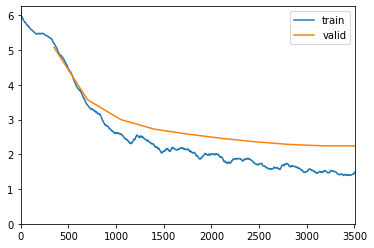

In [45]:
learn_lm.fit_one_cycle(10, lr, wd=0.1, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [46]:
learn_lm.save('fine_tune_lm_bwd')
learn_lm.save_encoder('fine_tune_enc_bwd')

## Train forward classifier

In [47]:
bs=8

In [48]:
data_lm = load_data("data/", "data_lm_export.pkl", bs=bs)

In [49]:
data_clas = (TextList.from_df(df_train, path, cols='text',
                              processor=SPProcessor.load(path))
                         .split_by_rand_pct(0.2, seed=seed)
                         .label_from_df(cols=0)
                         .databunch(bs=bs))

In [50]:
len(data_clas.vocab.itos), len(data_lm.vocab.itos)

(8552, 8552)

In [51]:
data_clas.save(path/'data/data_clas_export.pkl')

In [52]:
data_clas.show_batch()

text,target
"▁xxbos ▁o ▁xxup ▁subsecretário ▁xxup ▁de ▁xxup ▁administração ▁xxup ▁geral , ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁seg ura n ▁xxup ▁ ç a ▁xxup ▁pública ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁de ▁suas ▁atribuições ▁previstas ▁no ▁art . ▁30 ▁do ▁xxmaj ▁decreto ▁32.598 ▁/ ▁2010, ▁e ▁visa ndo ▁a ▁instrução ▁dos ▁autos ▁do ▁xxmaj ▁processo ▁no ▁xxrep ▁4 ▁0 ▁ 9",SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁de ▁suas ▁atribuições ▁legais , ▁e s - ▁ pe cial mente ▁as ▁previstas ▁no ▁art . ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁xxup ▁resolve : ▁xxup ▁exonerar , ▁por ▁estar ▁sendo ▁nomead a ▁para ▁outro ▁cargo , ▁xxup ▁raphael a ▁xxup ▁santos ▁xxup",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁camil a ▁xxup ▁beatri z ▁xxup ▁da ▁xxup ▁silva ▁xxup ▁oliveira ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁de ▁xxmaj ▁natureza ▁xxmaj ▁especial , ▁xxmaj ▁símbolo ▁xxup ▁cne",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁iii , ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁ s ever ino ▁xxup ▁de ▁xxup ▁sousa ▁xxup ▁oliveira ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁de ▁xxmaj ▁natureza ▁xxmaj ▁política , ▁xxmaj ▁símbolo",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁de ▁suas ▁atribuições ▁legais , ▁especial mente ▁as ▁previstas ▁no ▁art . ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁exonerar , ▁por ▁ter ▁ sido ▁nomead a ▁para ▁outro ▁cargo , ▁xxup ▁ ivani se ▁xxup ▁machado ▁xxup ▁fil gu eiras ▁xxup",PODER EXECUTIVO


In [53]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [54]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder("fine_tune_enc");

RNNLearner(data=TextClasDataBunch;

Train: LabelList (384 items)
x: TextList
▁xxbos ▁xxup ▁processo : ▁00150-000106 29 ▁/ ▁2018-72 ; ▁xxup ▁nota ▁xxup ▁de ▁xxup ▁empenho ▁xxmaj ▁no ▁01 1 00 ▁/ ▁2018; ▁xxup ▁das ▁xxup ▁partes : ▁xxup ▁df ▁/ ▁xxup ▁sec ▁/ ▁xxup ▁fac ▁x ▁xxup ▁santiago ▁xxup ▁machado ▁xxup ▁de lla pe . ▁xxmaj ▁na ▁qualidade ▁de ▁xxmaj ▁beneficiário ▁/ ▁a . ▁xxup ▁espécie : ▁xxmaj ▁termo ▁de ▁xxmaj ▁ajuste ▁xxmaj ▁no ▁7 06 ▁/ ▁2018; ▁xxup ▁modalidade : ▁xxmaj ▁seleção ▁xxmaj ▁pública ; ▁xxup ▁do ▁xxup ▁objeto : ▁o ▁presente ▁xxmaj ▁termo ▁de ▁xxmaj ▁ajuste ▁tem ▁por ▁objeto ▁a ▁concessão ▁de ▁apoio ▁financeiro ▁pelo ▁xxup ▁fundo ▁xxup ▁de ▁xxup ▁apoio ▁à ▁xxup ▁cultura ▁ao ▁xxmaj ▁programa ▁xxmaj ▁conexão ▁xxmaj ▁cultural ▁xxup ▁df ▁ # ▁xxmaj ▁negócios ▁de ▁interesse ▁do ▁/ ▁a ▁xxmaj ▁beneficiário ▁/ ▁a ▁acima ▁especificado ▁/ ▁a ; ▁xxup ▁do ▁xxup ▁valor : ▁xxup ▁r $ ▁ 15.000,00 ▁( quinze ▁mil ▁reais ) ▁que ▁será ▁libera do ▁em ▁parcela ▁única ▁e ▁transferido s ▁à ▁conta ▁

In [55]:
learn_c.freeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


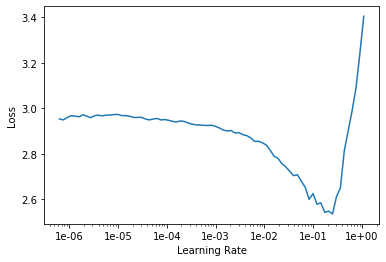

In [56]:
learn_c.recorder.plot()

In [57]:
lr=3e-2

In [58]:
learn_c.fit_one_cycle(5, lr, wd=0.3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.420215,1.940725,0.385417,0.358126,00:09
1,1.964753,1.508430,0.531250,0.490067,00:09
2,1.628235,1.395996,0.625000,0.594375,00:09
3,1.287825,1.174695,0.687500,0.694541,00:09
4,0.982696,1.026604,0.729167,0.708237,00:09


In [59]:
learn_c.save("clf_fwd")

In [60]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(5, slice(lr/(2.6**4),lr), wd=0.3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.940696,1.688801,0.552083,0.526978,00:09
1,1.361181,1.163793,0.635417,0.584898,00:09
2,1.150416,0.833198,0.770833,0.730091,00:09
3,0.776416,0.765295,0.822917,0.796637,00:09
4,0.471823,0.685559,0.812500,0.799475,00:09


In [61]:
learn_c.save("clf_fwd")

In [62]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(3, slice(lr/2/(2.6**4),lr/2), wd=0.3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.334820,1.015468,0.729167,0.734804,00:11
1,0.550087,0.711908,0.812500,0.801706,00:11
2,0.372841,0.678348,0.791667,0.787935,00:11


In [63]:
learn_c.save("clf_fwd")

In [64]:
learn_c.unfreeze()
learn_c.fit_one_cycle(5, slice(lr/10/(2.6**4),lr/10), wd=0.3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.184910,0.644883,0.822917,0.806035,00:15
1,0.174362,0.595416,0.843750,0.845935,00:15
2,0.148650,0.529046,0.854167,0.849243,00:15
3,0.106355,0.514202,0.843750,0.842646,00:15
4,0.091754,0.529347,0.875000,0.872804,00:15


In [65]:
learn_c.save("clf_fwd")

## Evaluate Forward CLF

In [134]:
data_clas = load_data(path/"data", "data_clas_export.pkl")

In [17]:
data_lm = load_data(path/"data", "data_lm_export.pkl")

In [18]:
data_test = (TextList.from_df(df_test, path, cols='text',
                              processor=SPProcessor.load(path))
                         .split_none()
                         .label_from_df(cols=0)
                         .databunch(bs=bs))

In [19]:
data_test.show_batch()

text,target
"▁xxbos ▁o ▁xxup ▁coordenador ▁xxup ▁de ▁xxup ▁inovação ▁e ▁xxup ▁gestão ▁xxup ▁do ▁xxup ▁conhecimento , ▁xxup ▁da ▁xxup ▁subsecretaria ▁xxup ▁de ▁xxup ▁gestão ▁xxup ▁de ▁xxup ▁pessoas ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁saúde ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁xxmaj ▁substituto , ▁no ▁uso ▁de ▁suas ▁atribuições ▁regimentais ▁e ▁considerando ▁o ▁disposto ▁no ▁xxmaj ▁art . ▁3° ▁do ▁xxmaj ▁decreto ▁no ▁39.61",SECRETARIA DE ESTADO DE SAÚDE
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere m ▁os ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁do ▁artigo ▁100, ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁o ▁xxup ▁ma j ▁xxup ▁qopm ▁xxup ▁peter c ley ▁xxup ▁franco ▁xxup ▁alves , ▁matrícula ▁ 50. 64 1 -9, ▁para ▁exercer ▁o ▁xxmaj",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁jos é ▁xxup ▁pereira ▁xxup ▁oliveira ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁em ▁xxmaj ▁comissão , ▁xxmaj ▁símbolo ▁xxup ▁df a - ▁10 , ▁de ▁xxmaj ▁assessor",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁tornar ▁xxup ▁sem ▁xxup ▁efeito ▁no ▁xxmaj ▁decreto ▁de ▁08 ▁de ▁janeiro ▁de ▁2019, ▁publicado ▁no ▁xxup ▁dodf ▁no ▁06 , ▁de ▁09 ▁de ▁janeiro ▁de ▁2019, ▁página",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁da vid ▁xxup ▁donizett i ▁xxup ▁da ▁xxup ▁silva , ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁em ▁xxmaj ▁comissão , ▁xxmaj ▁símbolo ▁xxup ▁dfg -12, ▁de ▁xxmaj",PODER EXECUTIVO


In [20]:
data_test.c, data_clas.c

(19, 19)

In [21]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [22]:
data_test.save(path/"data/test_data.pkl")

In [140]:
learn_c.load(path/"clf_fwd");

In [141]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


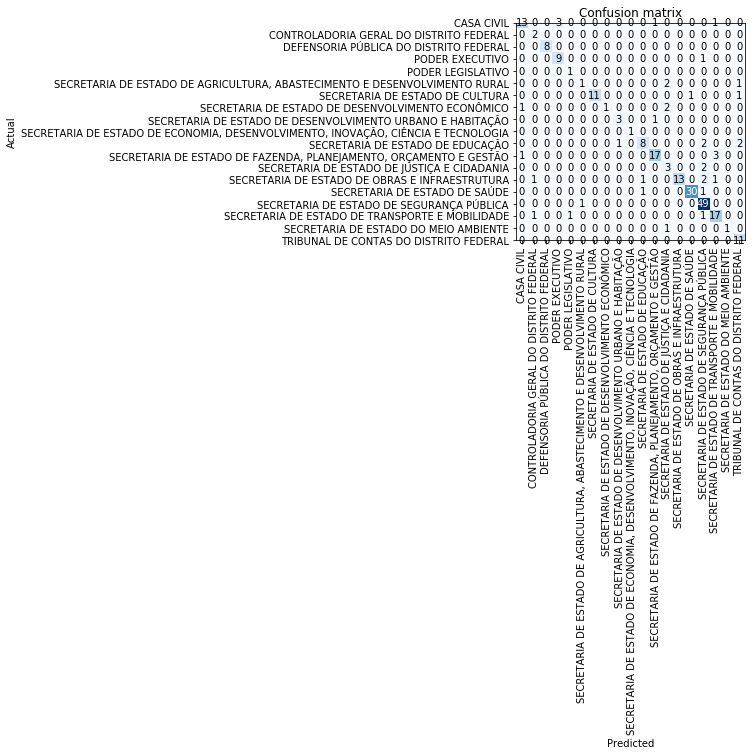

In [142]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [143]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([15,  3, 15,  3,  3, 15, 10, 15, 10,  3, 15, 14, 10, 15, 15]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [144]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.8667    0.7222    0.7879        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.5000    1.0000    0.6667         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.7500    0.9000    0.8182        10
                                                                PODER LEGISLATIVO     0.5000    1.0000    0.6667         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.5000    0.2500    0.3333         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               

In [145]:
learn_c.show_results()

text,target,prediction
"▁xxbos ▁o ▁xxup ▁coordenador ▁xxup ▁de ▁xxup ▁inovação ▁e ▁xxup ▁gestão ▁xxup ▁do ▁xxup ▁conhecimento , ▁xxup ▁da ▁xxup ▁subsecretaria ▁xxup ▁de ▁xxup ▁gestão ▁xxup ▁de ▁xxup ▁pessoas ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁saúde ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁xxmaj ▁substituto , ▁no ▁uso ▁de ▁suas ▁atribuições ▁regimentais ▁e ▁considerando ▁o ▁disposto ▁no ▁xxmaj ▁art . ▁3° ▁do ▁xxmaj ▁decreto ▁no ▁39.61",SECRETARIA DE ESTADO DE SAÚDE,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere m ▁os ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁do ▁artigo ▁100, ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁o ▁xxup ▁ma j ▁xxup ▁qopm ▁xxup ▁peter c ley ▁xxup ▁franco ▁xxup ▁alves , ▁matrícula ▁ 50. 64 1 -9, ▁para ▁exercer ▁o ▁xxmaj",PODER EXECUTIVO,PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁jos é ▁xxup ▁pereira ▁xxup ▁oliveira ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁em ▁xxmaj ▁comissão , ▁xxmaj ▁símbolo ▁xxup ▁df a - ▁10 , ▁de ▁xxmaj ▁assessor",PODER EXECUTIVO,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁tornar ▁xxup ▁sem ▁xxup ▁efeito ▁no ▁xxmaj ▁decreto ▁de ▁08 ▁de ▁janeiro ▁de ▁2019, ▁publicado ▁no ▁xxup ▁dodf ▁no ▁06 , ▁de ▁09 ▁de ▁janeiro ▁de ▁2019, ▁página",PODER EXECUTIVO,PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁da vid ▁xxup ▁donizett i ▁xxup ▁da ▁xxup ▁silva , ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁em ▁xxmaj ▁comissão , ▁xxmaj ▁símbolo ▁xxup ▁dfg -12, ▁de ▁xxmaj",PODER EXECUTIVO,PODER EXECUTIVO


In [78]:
txt_ci = TextClassificationInterpretation.from_learner(learn_c)

In [79]:
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
"▁xxbos ▁o ▁xxup ▁brb ▁- ▁xxup ▁banco ▁xxup ▁de ▁xxup ▁brasília ▁xxup ▁ s . a . ▁torna ▁público ▁que ▁a ▁xxmaj ▁comissão ▁xxmaj ▁administrativa ▁da ▁xxup ▁dipe s ▁ratifico u ▁o ▁ato ▁de ▁dispensa ▁de ▁licitação , ▁em ▁15.0 1. 19 , ▁nos ▁termos ▁do ▁artigo ▁6° ▁do ▁xxmaj ▁regulamento ▁de ▁xxmaj ▁licitações ▁e ▁xxmaj ▁contratos ▁xxup ▁( r lc - brb ), ▁para ▁a li enação ▁de ▁imóveis",SECRETARIA DE ESTADO DE SAÚDE,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO, ORÇAMENTO E GESTÃO",8.21,0.02
"▁xxbos ▁o ▁xxup ▁subsecretário ▁xxup ▁de ▁xxup ▁administração ▁xxup ▁geral , ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁justiça ▁e ▁xxup ▁cidadania ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁da ▁delega ção ▁de ▁competência ▁que ▁trata ▁o ▁artigo ▁2 o , ▁inciso ▁xxup ▁i , ▁alínea ▁"" j "" ▁da ▁xxmaj ▁portaria ▁n ° ▁65, ▁de ▁13 ▁de ▁maio ▁de ▁2013, ▁publicada",PODER EXECUTIVO,SECRETARIA DE ESTADO DE JUSTIÇA E CIDADANIA,6.74,0.00
"▁xxbos ▁a ▁xxup ▁subsecretária ▁xxup ▁de ▁xxup ▁gestão ▁xxup ▁de ▁xxup ▁pessoas , ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁educação ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁são ▁conferida s ▁pelo ▁artigo ▁4 o , ▁inciso ▁xxup ▁iii , ▁da ▁xxmaj ▁portaria ▁no ▁376 , ▁de ▁13 .11.2018 , ▁resolve : ▁xxup ▁homologar ▁o ▁resultado ▁da ▁avaliação ▁final ▁do",PODER EXECUTIVO,SECRETARIA DE ESTADO DE EDUCAÇÃO,6.70,0.01
"▁xxbos ▁o ▁xxup ▁secretário ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁educação ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁regimentais ▁que ▁lhe ▁são ▁conferida s ▁pelo ▁xxmaj ▁decreto ▁no ▁38.6 31, ▁de ▁20 ▁de ▁novembro ▁de ▁2017 ▁e ▁pelo ▁xxmaj ▁decreto ▁no ▁39.002 , ▁de ▁24 ▁de ▁abri l ▁de ▁2018, ▁e ▁considerando ▁o ▁disposto ▁no ▁art . ▁44, ▁da ▁xxmaj ▁lei ▁xxmaj ▁complementar ▁no ▁",SECRETARIA DE ESTADO DE TRANSPORTE E MOBILIDADE,SECRETARIA DE ESTADO DE EDUCAÇÃO,6.51,0.01
▁xxbos ▁xxmaj ▁contratante : ▁xxup ▁brb ▁- ▁xxup ▁banco ▁xxup ▁de ▁xxup ▁brasília ▁xxup ▁ s . a . ▁xxmaj ▁contratada : ▁xxup ▁ lo rinald o ▁xxup ▁batista ▁xxup ▁de ▁xxup ▁carvalho . ▁xxmaj ▁contrato ▁xxup ▁brb ▁- ▁2018 ▁/ ▁ 262 . ▁xxmaj ▁modalidade : ▁xxmaj ▁credenciamento ▁xxup ▁brb ▁no ▁001 ▁/ ▁2018. ▁xxmaj ▁objeto : ▁xxmaj ▁prestação ▁de ▁serviços ▁de ▁intermediação ▁de ▁venda ▁de ▁imóveis ▁não ▁de,TRIBUNAL DE CONTAS DO DISTRITO FEDERAL,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO, ORÇAMENTO E GESTÃO",5.83,0.02


## Train backwards classifier

In [80]:
bs=8

In [81]:
data_lm = load_data("data/", "data_lm_back.pkl", bs=bs, backwards=True)

In [82]:
data_lm.show_batch()

idx,text
0,"▁do ▁termos ▁nos , comprasnet ▁ ▁do ▁sítio ▁no ada ▁process ▁será ▁pública ▁xxmaj ▁sessão ▁xxmaj ▁a ). 3 ▁97400 : uasg ▁( ▁xxup br . gov . comprasnet . ww ▁w ▁e br . gov . df . tc . ww ▁w : ▁sítios ▁pelos ▁ou 742 ▁3314-2 61) ▁( ▁telefone , ▁tcdf ▁xxup ▁do ▁anexo ▁xxmaj . ▁ed ▁xxmaj ▁do ▁andar ▁xxmaj o ▁2 ▁no ▁localizado , ▁licitação"
1,"▁xxmaj ▁de ▁comissão ▁xxmaj stituírem ▁con , ▁primeiro ▁do ▁presidência ▁a ▁sob , ▁para -4; 45 ▁215.7 ▁no ▁matrícula , ▁ambiente ▁xxmaj ▁meio ▁xxmaj ▁do ▁atividades ▁xxmaj ▁de ▁analista ▁xxmaj , ▁mesquita ▁xxup ▁de ▁xxup ▁gonçalves ▁xxup o ▁fábi ▁xxup ▁luis ▁xxup ▁e ; x .259- 4 ▁26 ▁xxup ▁no ▁matrícula , ▁urbanas ▁xxmaj ▁atividades ▁xxmaj ▁de ▁fiscal ▁xxmaj ▁auditora ▁xxmaj , ▁mendes ▁xxup ▁moraes ▁xxup ▁de ▁xxup a ▁flávi"
2,"▁especial ▁xxmaj ▁natureza ▁xxmaj ▁de ▁cargo ▁xxmaj ▁o ▁exercer ▁para 88-2, 4 ▁39. ▁no ▁matrícula , ▁professor ▁xxmaj , ▁aguiar ▁xxup ▁de ▁xxup ▁domingues ▁xxup line ke ▁jac ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁educação ▁xxmaj ▁de ▁estado ▁xxmaj ▁de ▁secretaria ▁xxmaj ▁da , ▁básica ▁xxmaj ▁educação ▁xxmaj ▁de ▁subsecretaria ▁xxmaj ▁da , is versa ▁trans ▁xxmaj is ▁educaciona ▁xxmaj ▁políticas ▁xxmaj ▁de ▁coordenação ▁xxmaj ▁da ,"
3,"▁ ▁matricula ▁araujo ▁xxup ▁de ▁xxup ▁rodolfo ▁xxup ▁a ▁aposentadoria ▁concedeu ▁que ▁ato ▁o ▁2018, ▁de ▁dezembro ▁de ▁27 ▁de , ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁oficial ▁xxmaj ▁diário ▁xxmaj ▁no ▁publicada ▁2018, ▁de ▁dezembro ▁de ▁26 ▁de , ▁serviço ▁xxmaj ▁de ▁ordem ▁xxmaj ▁na ▁retificar ▁xxup . ▁2018-00 ▁/ 28 ▁61 ▁0 ▁4 ▁xxrep ▁00410- ▁processo ▁xxmaj ▁2018. ▁de lho ▁ju ▁de ▁04 ▁de ▁contar ▁a ▁efeitos ▁seus ▁com"
4,"▁xxmaj , ▁próprios ▁xxup ▁recursos ▁xxup : ▁recursos ▁xxup ▁de ▁xxup ▁fonte ▁xxup ; 33.90.30 . ▁6977 ▁/ 17.122.6001.8517 ▁ : ▁despesa ▁xxup ▁de ▁xxup ▁natureza ▁xxup ▁/ ▁trabalho ▁xxup ▁de ▁xxup ▁programa ▁xxup . ▁22.202 : ▁uo ▁xxup : ▁orçamentária ▁xxup ▁dotação ▁xxup . o ug tar ▁ ▁e "" u ▁"" ▁xxup ▁em il perf ▁ , o ç ▁a ▁em on ▁metal , to cha ▁ ▁ferro"


In [83]:
data_clas = (TextList.from_df(df_train, path, cols='text',
                              processor=SPProcessor.load(path))
                         .split_by_rand_pct(0.2, seed=seed)
                         .label_from_df(cols=0)
                         .databunch(bs=bs, backwards=True))

In [84]:
len(data_clas.vocab.itos), len(data_lm.vocab.itos)

(8552, 8552)

In [85]:
data_clas.save(path/'data/data_clas_bwd.pkl')

In [86]:
data_clas.show_batch()

text,target
", no ▁maria ▁xxup ▁silva ▁xxup ▁da ▁xxup ▁rodrigo ▁xxup 5; 11 941 02 730 ▁ , ▁gomes ▁xxup ▁silva ▁xxup ▁da ▁xxup ▁rodrigo ▁xxup 3; 316 21 094 ▁04 , ▁azevedo ▁xxup ▁barros ▁xxup ▁silva ▁xxup ▁da ▁xxup ▁rodrigo ▁xxup ; 172 51 73 46 71 ▁ , ▁silva ▁xxup ▁da ▁xxup to ara chi ▁ ▁xxup ▁rodrigo ▁xxup ; 00 61 553 82 ▁68 , ▁paiva ▁xxup ▁de",SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA
"▁a ▁da , ▁assessor ▁xxmaj ▁de -12, a ▁df ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em ▁cargo ▁xxmaj ▁no ▁pereira ▁xxup ▁oliveira ▁xxup ▁de ▁xxup e ▁dayan ▁xxup ▁nomear ▁xxup . ▁df ▁xxup ▁/ slu - ▁federal ▁distrito ▁xxmaj ▁do ▁urbana ▁xxmaj ▁limpeza ▁xxmaj ▁de ▁serviço ▁xxmaj ▁do , ▁mobilização ▁xxmaj ▁e ▁comunicação ▁xxmaj ▁de ▁assessoria ▁xxmaj ▁da , ▁especial ▁xxmaj ▁assessor ▁xxmaj ▁de , -06 ▁cne ▁xxup ▁símbolo ▁xxmaj",PODER EXECUTIVO
"no ▁bren ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁educação ▁xxmaj ▁de ▁estado ▁xxmaj ▁de ▁secretaria ▁xxmaj ▁da , ▁tecnologia ▁xxmaj ▁e ▁modernização ▁xxmaj ▁de ▁subsecretaria ▁xxmaj ▁da , ▁informática ▁xxmaj ▁de ▁coordenação ▁xxmaj ▁da , ▁sistemas ▁xxmaj ▁de ▁desenvolvimento ▁xxmaj ▁de ▁diretoria ▁xxmaj ▁da , ▁diretor ▁xxmaj ▁de -07, ▁cne ▁xxup ▁símbolo ▁xxmaj , ▁especial ▁xxmaj ▁natureza ▁xxmaj ▁de ▁cargo ▁xxmaj ▁o ▁exercer ▁para ▁mello ▁xxup ▁silveira",PODER EXECUTIVO
"▁ger ▁xxmaj ▁da , ▁gerente ▁xxmaj ▁de -14, ▁dfg ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em ▁cargo ▁xxmaj ▁o ▁exercer ▁para ▁araujo ▁xxup ▁de ▁xxup ▁conceição ▁xxup ▁da ▁xxup mar ▁ed ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁abastecimento ▁xxmaj ▁e ▁indústria ▁xxmaj ▁de ▁complementar ▁xxmaj ▁setor ▁xxmaj ▁do ▁regional ▁xxmaj ▁administração ▁xxmaj ▁da , ▁manutenção ▁xxmaj ▁e ▁obras ▁xxmaj , ▁licenciamento ▁xxmaj ▁de ▁coordenação ▁xxmaj ▁da ,",PODER EXECUTIVO
"▁de ▁xxmaj ▁no ▁efeito ▁xxup ▁sem ▁xxup ▁tornar ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁lazer ▁xxmaj ▁e ▁esporte ▁xxmaj ▁de ▁estado ▁xxmaj ▁de ▁secretaria ▁xxmaj ▁da , ▁geral ▁xxmaj ▁administração ▁xxmaj ▁de ▁subsecretaria ▁xxmaj ▁da , ▁pessoas ▁xxmaj ▁de ▁gestão ▁xxmaj ▁de ▁diretoria ▁xxmaj ▁da , ▁diretor ▁xxmaj ▁de -07, ▁cne ▁xxup ▁símbolo ▁xxmaj , ▁especial ▁xxmaj ▁natureza ▁xxmaj ▁de ▁cargo ▁xxmaj ▁pelo , is ▁norma ▁atribuições ▁suas ▁de",PODER EXECUTIVO


In [87]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [88]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder("fine_tune_enc_bwd");

In [89]:
learn_c.freeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


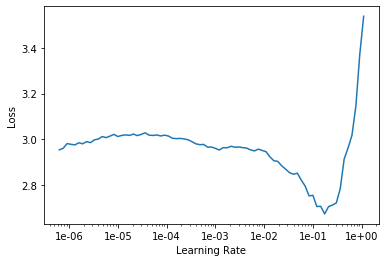

In [90]:
learn_c.recorder.plot()

In [91]:
lr=3e-2

In [92]:
learn_c.fit_one_cycle(5, lr, wd=0.3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.539612,2.015352,0.447917,0.410614,00:09
1,2.050961,1.528385,0.572917,0.541348,00:09
2,1.773224,1.509777,0.572917,0.519346,00:09
3,1.515306,1.315756,0.625000,0.603956,00:09
4,1.169530,1.206786,0.677083,0.661065,00:09


In [93]:
learn_c.save("clf_bwd")

In [94]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(5, slice(lr/(2.6**4),lr), wd=0.3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.095853,1.289530,0.656250,0.598341,00:09
1,1.514207,1.476104,0.562500,0.501294,00:09
2,1.294139,1.009767,0.729167,0.718091,00:09
3,0.955501,0.697498,0.822917,0.782417,00:09
4,0.598271,0.608211,0.822917,0.788696,00:09


In [95]:
learn_c.save("clf_bwd")

In [96]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(3, slice(lr/2/(2.6**4),lr/2), wd=0.3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.376501,0.783587,0.770833,0.759974,00:11
1,0.596748,0.644821,0.843750,0.832202,00:11
2,0.429919,0.539610,0.854167,0.848557,00:11


In [97]:
learn_c.save("clf_bwd")

In [98]:
learn_c.unfreeze()
learn_c.fit_one_cycle(5, slice(lr/10/(2.6**4),lr/10), wd=0.3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.256314,0.504834,0.885417,0.881042,00:15
1,0.232434,0.504226,0.875000,0.868255,00:15
2,0.180628,0.452917,0.885417,0.885621,00:15
3,0.135171,0.433663,0.906250,0.907018,00:15
4,0.117223,0.446915,0.906250,0.906264,00:15


In [99]:
learn_c.save("clf_bwd")

## Evaluate bwd clf

In [12]:
data_clas = load_data(path/"data", "data_clas_bwd.pkl", backwards=True)

In [13]:
data_test = (TextList.from_df(df_test, path, cols='text',
                              processor=SPProcessor.load(path))
                         .split_none()
                         .label_from_df(cols=0)
                         .databunch(bs=bs, backwards=True))

In [14]:
data_test.show_batch()

text,target
▁c ▁costa ▁xxup lio ▁aure ▁xxup ▁marco ▁xxup ; x - 53 28 ▁015 ▁xxup ▁- ; ▁enfermagem ▁xxup ▁de ▁xxup ▁auxiliar ▁xxup ▁- 02 - 10 80 ▁ <unk> ▁ ▁2019 ▁/ ▁01 ▁/ ▁12 ; ▁iv ▁xxup ▁segunda ▁xxup ; ▁iii ▁xxup ▁segunda ▁xxup ; ▁silva ▁xxup ▁da ▁xxup ▁cunha ▁xxup a ▁renat ▁xxup 9-7; 00 75 ▁01 ▁- ▁2019; ▁/ ▁01 ▁/ ▁12 ; ▁iv ▁xxup ▁segunda,SECRETARIA DE ESTADO DE SAÚDE
"er ▁ex ▁para 8, 085 74 ▁16 gdf ▁ ▁xxup ▁matrícula , do e ▁figuer ▁xxup ▁de ▁xxup no ja tra ▁ ▁xxup ▁joão ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁militar ▁xxmaj ▁casa ▁xxmaj ▁da , ▁serviços ▁xxmaj ▁de ▁gestão ▁xxmaj ▁de a fi e h c ▁sub ▁xxmaj ▁da , ▁buriti ▁xxmaj ▁do ácio ▁pal ▁xxmaj ▁do ▁manutenção ▁xxmaj ▁e imento r sup ▁ ▁xxmaj ▁de",PODER EXECUTIVO
"í ▁matr , ▁moura ▁xxup ▁de ▁xxup ▁fernandes ▁xxup las ug ▁do ▁xxup ▁polícia ▁xxmaj ▁de legado ▁de ▁xxmaj ▁o ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁civil ▁xxmaj ▁polícia ▁xxmaj ▁da , cional cri ▁circuns ▁xxmaj ▁polícia ▁xxmaj ▁de ▁departamento ▁xxmaj ▁do , ▁polícia ▁xxmaj ▁de cia ▁delega ▁xxmaj a ▁4 ▁da ▁chefe ▁xxmaj legado ▁de ▁xxmaj ▁de 17, - ▁dfg ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em",PODER EXECUTIVO
"▁empregador ▁xxmaj ▁e r ▁trabalhado ▁xxmaj ▁ao ▁atendimento ▁xxmaj ▁de ▁subsecretaria ▁xxmaj ▁da , ▁empregador ▁xxmaj ▁o ▁e r ▁trabalhado ▁xxmaj ▁o ▁para ▁ações ▁xxmaj ▁de ▁coordenação ▁xxmaj ▁da , r ▁trabalhado ▁xxmaj ▁o ▁para ▁ações ▁xxmaj ▁de ▁diretoria ▁xxmaj ▁da , ▁maria ▁xxmaj ▁santa ▁xxmaj ▁de r ▁trabalhado ▁xxmaj ▁ao ▁atendimento ▁xxmaj ▁de ▁agência ▁xxmaj ▁da , ▁assessor ▁xxmaj ▁de -12, a ▁df ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj",PODER EXECUTIVO
"▁de -12, ▁dfg ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em ▁cargo ▁xxmaj ▁o ▁exercer ▁para -0, .556 ▁175 ▁matrícula , gi bia ▁ ▁xxup ▁maciel ▁xxup ▁costa ▁xxup ▁regina ▁xxup a e h d y l ▁ ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do l na go o ct ▁o ▁xxmaj ▁/ ▁sudoeste ▁xxmaj ▁do ▁regional ▁xxmaj ▁administração ▁xxmaj ▁da , ▁gabinete ▁xxmaj ▁do , ▁planejamento ▁xxmaj ▁de",PODER EXECUTIVO


In [15]:
data_test.c, data_clas.c

(19, 19)

In [16]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [17]:
data_test.save(path/"data/test_data_bwd.pkl")

In [120]:
learn_c.load(path/"clf_bwd");

In [130]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


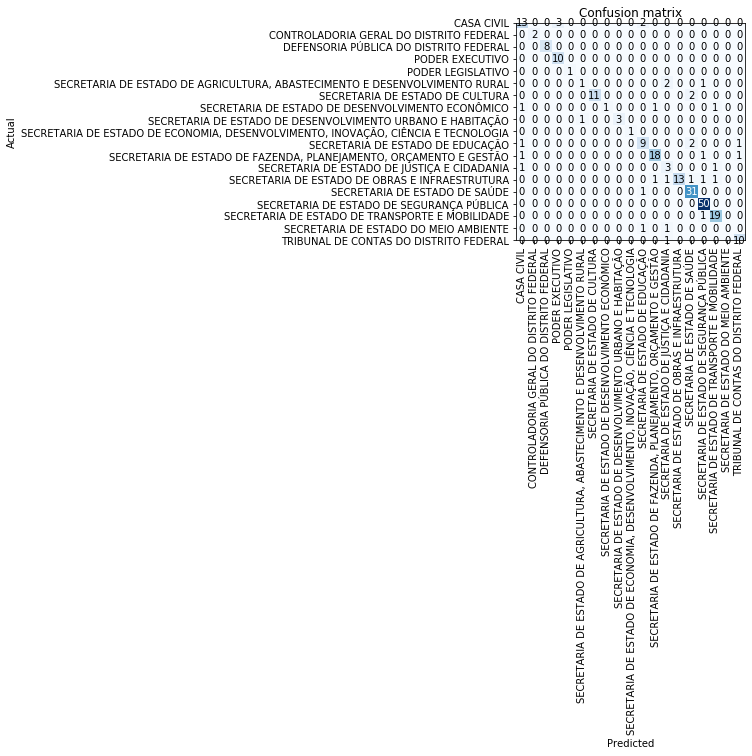

In [131]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [132]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([14,  3,  3,  3,  3, 10, 14, 10, 10,  3, 15, 14, 10, 15, 15]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [133]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.7647    0.7222    0.7429        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.7692    1.0000    0.8696        10
                                                                PODER LEGISLATIVO     1.0000    1.0000    1.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.5000    0.2500    0.3333         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [110]:
learn_c.show_results()

text,target,prediction
▁c ▁costa ▁xxup lio ▁aure ▁xxup ▁marco ▁xxup ; x - 53 28 ▁015 ▁xxup ▁- ; ▁enfermagem ▁xxup ▁de ▁xxup ▁auxiliar ▁xxup ▁- 02 - 10 80 ▁ <unk> ▁ ▁2019 ▁/ ▁01 ▁/ ▁12 ; ▁iv ▁xxup ▁segunda ▁xxup ; ▁iii ▁xxup ▁segunda ▁xxup ; ▁silva ▁xxup ▁da ▁xxup ▁cunha ▁xxup a ▁renat ▁xxup 9-7; 00 75 ▁01 ▁- ▁2019; ▁/ ▁01 ▁/ ▁12 ; ▁iv ▁xxup ▁segunda,SECRETARIA DE ESTADO DE SAÚDE,SECRETARIA DE ESTADO DE SAÚDE
"er ▁ex ▁para 8, 085 74 ▁16 gdf ▁ ▁xxup ▁matrícula , do e ▁figuer ▁xxup ▁de ▁xxup no ja tra ▁ ▁xxup ▁joão ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁militar ▁xxmaj ▁casa ▁xxmaj ▁da , ▁serviços ▁xxmaj ▁de ▁gestão ▁xxmaj ▁de a fi e h c ▁sub ▁xxmaj ▁da , ▁buriti ▁xxmaj ▁do ácio ▁pal ▁xxmaj ▁do ▁manutenção ▁xxmaj ▁e imento r sup ▁ ▁xxmaj ▁de",PODER EXECUTIVO,PODER EXECUTIVO
"í ▁matr , ▁moura ▁xxup ▁de ▁xxup ▁fernandes ▁xxup las ug ▁do ▁xxup ▁polícia ▁xxmaj ▁de legado ▁de ▁xxmaj ▁o ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁civil ▁xxmaj ▁polícia ▁xxmaj ▁da , cional cri ▁circuns ▁xxmaj ▁polícia ▁xxmaj ▁de ▁departamento ▁xxmaj ▁do , ▁polícia ▁xxmaj ▁de cia ▁delega ▁xxmaj a ▁4 ▁da ▁chefe ▁xxmaj legado ▁de ▁xxmaj ▁de 17, - ▁dfg ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em",PODER EXECUTIVO,PODER EXECUTIVO
"▁empregador ▁xxmaj ▁e r ▁trabalhado ▁xxmaj ▁ao ▁atendimento ▁xxmaj ▁de ▁subsecretaria ▁xxmaj ▁da , ▁empregador ▁xxmaj ▁o ▁e r ▁trabalhado ▁xxmaj ▁o ▁para ▁ações ▁xxmaj ▁de ▁coordenação ▁xxmaj ▁da , r ▁trabalhado ▁xxmaj ▁o ▁para ▁ações ▁xxmaj ▁de ▁diretoria ▁xxmaj ▁da , ▁maria ▁xxmaj ▁santa ▁xxmaj ▁de r ▁trabalhado ▁xxmaj ▁ao ▁atendimento ▁xxmaj ▁de ▁agência ▁xxmaj ▁da , ▁assessor ▁xxmaj ▁de -12, a ▁df ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj",PODER EXECUTIVO,PODER EXECUTIVO
"▁de -12, ▁dfg ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em ▁cargo ▁xxmaj ▁o ▁exercer ▁para -0, .556 ▁175 ▁matrícula , gi bia ▁ ▁xxup ▁maciel ▁xxup ▁costa ▁xxup ▁regina ▁xxup a e h d y l ▁ ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do l na go o ct ▁o ▁xxmaj ▁/ ▁sudoeste ▁xxmaj ▁do ▁regional ▁xxmaj ▁administração ▁xxmaj ▁da , ▁gabinete ▁xxmaj ▁do , ▁planejamento ▁xxmaj ▁de",PODER EXECUTIVO,PODER EXECUTIVO


In [111]:
txt_ci = TextClassificationInterpretation.from_learner(learn_c)

In [112]:
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
"▁xxbos ▁o ▁xxup ▁brb ▁- ▁xxup ▁banco ▁xxup ▁de ▁xxup ▁brasília ▁xxup ▁ s . a . ▁torna ▁público ▁que ▁a ▁xxmaj ▁comissão ▁xxmaj ▁administrativa ▁da ▁xxup ▁dipe s ▁ratifico u ▁o ▁ato ▁de ▁dispensa ▁de ▁licitação , ▁em ▁15.0 1. 19 , ▁nos ▁termos ▁do ▁artigo ▁6° ▁do ▁xxmaj ▁regulamento ▁de ▁xxmaj ▁licitações ▁e ▁xxmaj ▁contratos ▁xxup ▁( r lc - brb ), ▁para ▁a li enação ▁de ▁imóveis",SECRETARIA DE ESTADO DE SAÚDE,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO, ORÇAMENTO E GESTÃO",7.93,0.01
▁xxbos ▁xxmaj ▁contratante : ▁xxup ▁brb ▁- ▁xxup ▁banco ▁xxup ▁de ▁xxup ▁brasília ▁xxup ▁ s . a . ▁xxmaj ▁contratada : ▁xxup ▁ lo rinald o ▁xxup ▁batista ▁xxup ▁de ▁xxup ▁carvalho . ▁xxmaj ▁contrato ▁xxup ▁brb ▁- ▁2018 ▁/ ▁ 262 . ▁xxmaj ▁modalidade : ▁xxmaj ▁credenciamento ▁xxup ▁brb ▁no ▁001 ▁/ ▁2018. ▁xxmaj ▁objeto : ▁xxmaj ▁prestação ▁de ▁serviços ▁de ▁intermediação ▁de ▁venda ▁de ▁imóveis ▁não ▁de,SECRETARIA DE ESTADO DE SAÚDE,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO, ORÇAMENTO E GESTÃO",6.43,0.00
"▁xxbos ▁o ▁xxup ▁subsecretário ▁xxup ▁de ▁xxup ▁administração ▁xxup ▁geral , ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁justiça ▁e ▁xxup ▁cidadania ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁da ▁delega ção ▁de ▁competência ▁que ▁trata ▁o ▁artigo ▁2 o , ▁inciso ▁xxup ▁i , ▁alínea ▁"" j "" ▁da ▁xxmaj ▁portaria ▁n ° ▁65, ▁de ▁13 ▁de ▁maio ▁de ▁2013, ▁publicada",PODER EXECUTIVO,SECRETARIA DE ESTADO DE JUSTIÇA E CIDADANIA,5.27,0.00
"▁xxbos ▁o ▁xxup ▁diretor ▁xxup ▁do ▁xxup ▁departamento ▁xxup ▁de ▁xxup ▁gestão ▁xxup ▁de ▁xxup ▁pessoas , ▁xxup ▁da ▁xxup ▁polícia ▁xxup ▁civil ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁de ▁suas ▁atribuições ▁legais ▁e ▁ tendo ▁em ▁vista ▁a ▁delega ção ▁de ▁competência ▁que ▁lhe ▁foi ▁conferida ▁pela ▁alínea ▁"" a "", ▁inciso ▁xxup ▁ii , ▁artigo ▁1 o , ▁da ▁xxmaj ▁portaria ▁no ▁25, ▁de ▁18",SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,4.79,0.45
▁xxbos ▁xxup ▁processo ▁xxmaj ▁no ▁092.006 00 6 ▁/ ▁2018. ▁xxup ▁objeto : ▁xxmaj ▁aquisição ▁e ▁instalação ▁de ▁conjunto s ▁ moto r ▁bomba ▁para ▁a ▁eleva tória ▁de ▁água ▁ br u ta ▁do ▁sistema ▁xxmaj ▁santa ▁xxmaj ▁maria ▁/ ▁xxmaj ▁ to r to . ▁xxup ▁dotação ▁xxup ▁orçamentária : ▁xxup ▁uo : ▁22.202 ; ▁xxup ▁programa ▁xxup ▁de ▁xxup ▁trabalho : ▁17 . 51 2.6210. 70 06,SECRETARIA DE ESTADO DE TRANSPORTE E MOBILIDADE,SECRETARIA DE ESTADO DE OBRAS E INFRAESTRUTURA,4.59,0.03


## Bwd + Fwd

In [18]:
bs = 8

In [19]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [20]:
data_clas = load_data(path/"data", "data_clas_export.pkl", bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1])
learn_c.path = path
learn_c.load("clf_fwd");

In [21]:
data_test = load_data(path/"data", "test_data.pkl", bs=bs)

In [22]:
learn_c.data.valid_dl = data_test.fix_dl

In [23]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs)

tensor(0.8397)

In [24]:
data_clas_bwd = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.path = path
learn_c_bwd.load("clf_bwd");

In [26]:
data_test_bwd = load_data(path/"data", "test_data_bwd.pkl", bs=bs, backwards=True)

In [27]:
learn_c_bwd.data.valid_dl = data_test_bwd.fix_dl

In [29]:
preds_bwd,targs_bwd = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_bwd,targs_bwd)

tensor(0.8608)

In [32]:
preds_avg = (preds+preds_bwd)/2
accuracy(preds_avg, targs)

tensor(0.8692)

In [33]:
predictions = np.argmax(preds_avg, axis = 1)

In [35]:
print(classification_report(targs, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(targs, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.8235    0.7778    0.8000        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.7692    1.0000    0.8696        10
                                                                PODER LEGISLATIVO     0.5000    1.0000    0.6667         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     1.0000    0.2500    0.4000         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               